In [1]:
# deep learning 
import tensorflow as tf #YD: add.compat.v1 to invert to earlier version
# tf.disable_v2_behavior() #YD
import keras.backend as K
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
# general tools
import os
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *

2024-04-16 21:24:09.540268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
MeanAct = lambda x: tf.clip_by_value(x, 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    # from sklearn.utils.linear_assignment_ import linear_assignment
    # ind = linear_assignment(w.max() - w)
    # return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    row_ind, col_ind = linear_assignment(w.max() - w) # YD Change
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size # YD Change

# def multinomial(x, p):
#     print("Runtime shape of x:", x.shape)
#     print("Runtime shape of p:", p.shape) 
#     loss = tf.reduce_mean(-x * tf.math.log(tf.clip_by_value(p, 1e-12, 1.0)))
#     return loss
def multinomial(y_true, y_pred):
    loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
    return loss

def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)


In [3]:
class scDMFK(object):
    def __init__(self, output_dir, input_size, output_size,
                 dims=[64,32,64], alpha=0.001, sigma=1.0, learning_rate=0.001,
                 theta=1, cluster_num=1, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True):
        self.output_dir = output_dir
        self.input_size = input_size
        self.output_size = output_size
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.model = None
        self.loss = None
        self.optimizer = None
        # self.n_stacks = len(self.dims) - 1 #=0
        
        # input layer
        self.x_count = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        # latent layers
        self.h = self.x_count
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        for i, hid_size in enumerate(self.dims):
            center_idx = int(np.floor(len(self.dims) / 2.0))
            if i == center_idx:
                layer_name = 'hidden'
                self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init,
                                    name=layer_name)(self.h)  # hidden layer, features are extracted from here
                self.h = self.latent
            elif i < center_idx:
                layer_name = 'encoder%s' % i
                self.h = Dense(units=hid_size, kernel_initializer=self.init, name=layer_name)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
            else:
                layer_name = 'decoder%s' % (i-center_idx)
                self.h = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init,
                           name=layer_name)(self.h)    
        # output layer
        self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
        self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
        self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
        self.P = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))

        # put together full model architecture
        self.model = Model(inputs=[self.x_count, self.sf_layer], outputs=self.P)
        self.pre_loss = multinomial
        
    def predict(self, adata, mode='denoise', copy=False):      
        adata = adata.copy() if copy else adata
    
        print('Calculating reconstructions...')
        adata.X = self.model.predict({'count': adata.X, 'size_factors': adata.obs.size_factors})
    
        return adata if copy else None

    def write(self, adata, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values if rownames is None else rownames 
        
        data_path = 'data/' + self.output_dir + '/'
        os.makedirs(data_path, exist_ok=True)
        print('scDMFK: Saving output(s) to %s' % data_path)
        
        write_text_matrix(adata.X,
                          os.path.join(data_path, 'mean-scdm.csv'),
                          rownames=rownames, colnames=colnames, transpose=False)

    def pretrain(self, adata, size_factor, batch_size, pretrain_epoch, gpu_option):
        print("begin the pretraining")
        
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
        config_ = tf.compat.v1.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        
        tf.compat.v1.keras.backend.set_session(
            tf.compat.v1.Session(
                config=config_
            )
        )
        # init = tf.group(tf.compat.v1.global_variables_initializer(), 
        #                 tf.compat.v1.local_variables_initializer())
        # self.sess = tf.compat.v1.Session(config=config_)
        # self.sess.run(init)
        
        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.model.compile(loss=self.pre_loss, optimizer=self.optimizer)
        
        inputs = {'count': adata.X , 'size_factors': size_factor}
        raw_probs = pd.DataFrame(adata.raw.X / adata.raw.X.sum(1)[:,np.newaxis],columns=adata.raw.var_names)
        high_variable_probs = raw_probs[adata.var_names]
        # get multinomial probabilities
        output = high_variable_probs.to_numpy()

        self.model.fit(inputs, output,
                        epochs=pretrain_epoch,
                        batch_size=batch_size)
            


In [9]:
def normalize(adata, highly_genes = None, size_factors=True, normalize_input=True, logtrans_input=True):
    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_counts=1)
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)
          
    highly_genes = adata.n_vars if None else highly_genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = highly_genes, subset=True)

    return adata

In [4]:
dataname = "/home/dengyf2000/bis687-project/data/endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
adata = prepro(dataname)
if transpose:
    adata = adata.transpose()
adata = normalize(adata, highly_genes=highly_genes)
high_variable = adata.var.highly_variable

X = adata.X.astype(np.float32)
count_X = X
count_X = count_X[:, high_variable]
input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

Successfully preprocessed 1018 genes and 19097 cells


In [5]:
high_variable_raw = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names)[adata.var_names]
high_variable_raw

,ABTB1,APOA2,HIST1H2BC,RSPH9,MT-ND4,HIST1H4F,TNNT2,GSDMD,FBXL17,DDI2,...,ADAMTS7,TCEANC,ITGA9,LRRC2,PDE11A,CCDC144NL,SYDE1,NTNG1,DDA1,EPSTI1
0,0.0,0.0,0.0,10.0,9283.0,0.0,0.0,31.0,0.0,0.0,...,0.0,2.0,0.0,18.0,14.0,0.0,2.0,0.0,13.0,0.0
1,28.0,0.0,2.0,15.0,16546.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,46.0,15.0,0.0,0.0,0.0,79.0,0.0
2,0.0,0.0,0.0,0.0,10799.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,33.0,18.0,0.0,0.0,0.0,9.0,0.0
3,1.0,0.0,3.0,0.0,11254.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,5.0,51.0,25.0,0.0,0.0,0.0,21.0,0.0
4,0.0,0.0,0.0,0.0,7306.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,22.0,13.0,0.0,0.0,0.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0.0,0.0,0.0,0.0,16914.0,0.0,210.0,1.0,0.0,0.0,...,0.0,0.0,7.0,139.0,41.0,0.0,0.0,0.0,110.0,146.0
1014,0.0,0.0,0.0,0.0,23235.0,0.0,0.0,86.0,0.0,0.0,...,0.0,3.0,7.0,167.0,38.0,0.0,0.0,0.0,169.0,539.0
1015,3.0,0.0,0.0,0.0,10147.0,0.0,2.0,1.0,0.0,0.0,...,0.0,3.0,181.0,85.0,10.0,0.0,0.0,0.0,331.0,0.0
1016,39.0,0.0,0.0,0.0,19616.0,0.0,490.0,1.0,0.0,0.0,...,0.0,16.0,75.0,245.0,49.0,0.0,0.0,0.0,254.0,21.0


In [6]:
model = scDMFK(output_dir, input_size, output_size)
model.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=100, gpu_option='0')

2024-04-16 21:25:33.580292: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-16 21:25:33.642190: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-16 21:25:33.642245: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-16 21:25:33.642285: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240411-194221): /proc/driver/nvidia/version does not exist
2024-04-16 21:25:33.644721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI D

begin the pretraining



2024-04-16 21:25:34.665373: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-16 21:25:35.237620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-16 21:25:35.344553: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200155000 Hz


Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 1.5316e-04
Epoch 2/100
16/16 [==============================] - 1s 41ms/step - loss: 1.2735e-04
Epoch 3/100
16/16 [==============================] - 1s 51ms/step - loss: 1.1742e-04
Epoch 4/100
16/16 [==============================] - 1s 53ms/step - loss: 1.1186e-04
Epoch 5/100
16/16 [==============================] - 1s 55ms/step - loss: 1.0784e-04
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 1.0498e-04
Epoch 7/100
16/16 [==============================] - 1s 50ms/step - loss: 1.0320e-04
Epoch 8/100
16/16 [==============================] - 1s 65ms/step - loss: 1.0096e-04
Epoch 9/100
16/16 [==============================] - 0s 26ms/step - loss: 9.9151e-05
Epoch 10/100
16/16 [==============================] - 0s 29ms/step - loss: 9.9950e-05
Epoch 11/100
16/16 [==============================] - 0s 26ms/step - loss: 9.6859e-05
Epoch 12/100
16/16 [==============================] - 1s 39ms/s

In [30]:
# model.predict(adata)
end_scdm = pd.DataFrame(adata.X, 
                        index=adata.obs_names,
                        columns=adata.var_names) * adata.raw.X.sum(1)[:, np.newaxis]
# end_scdm.to_csv('/home/dengyf2000/bis687-project/data/endoderm/results/mean-scdm-100.csv', index=False)

array([[4.3882477e-01, 2.7483484e-02, 4.3019375e-01, ..., 3.8765466e-01,
        1.2085359e+03, 2.5390968e+02],
       [7.4374580e-01, 4.0953435e-02, 7.2051102e-01, ..., 6.6699034e-01,
        1.5353749e+03, 2.3141936e+02],
       [6.1162186e-01, 2.3359867e-02, 5.9472269e-01, ..., 5.5030560e-01,
        1.1135233e+03, 2.3376602e+02],
       ...,
       [1.0590173e+00, 2.0624233e-02, 1.0718365e+00, ..., 7.6516259e-01,
        4.3131694e+03, 7.2063032e+03],
       [1.0185248e+00, 2.1972844e-02, 1.0175899e+00, ..., 7.0381510e-01,
        4.2592959e+03, 6.9324590e+03],
       [9.5747954e-01, 1.7120887e-02, 9.7531921e-01, ..., 7.0172453e-01,
        4.0688574e+03, 5.0822036e+03]], dtype=float32)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plotting tools 
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_embedding(data):
    """ Function to compute the UMAP embedding"""
    data_scaled = StandardScaler().fit_transform(data)

    embedding = umap.UMAP(n_neighbors=10,
                            min_dist=0.5,
                            metric='correlation',
                            random_state=16).fit_transform(data_scaled)
    return embedding


def draw_umap(embedding, label):
    contour_c = '#444444'
    labelsize = 25
    label = label
    palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))

    fig, ax = plt.subplots(figsize=(20, 15))

    plt.xlim([np.min(embedding[:, 0]) - 0.5, np.max(embedding[:, 0]) + 1.5])
    plt.ylim([np.min(embedding[:, 1]) - 0.5, np.max(embedding[:, 1]) + 0.5])
    plt.xlabel('UMAP 1', fontsize=labelsize)
    plt.ylabel('UMAP 2', fontsize=labelsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plt.scatter(embedding[:, 0], embedding[:, 1], lw=0, , label=label, alpha=1.0, s=180, linewidth=2)
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, 
                hue_order=list(np.unique(label)), palette=palette)
    leg = plt.legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
    leg.get_frame().set_alpha(0.9)
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


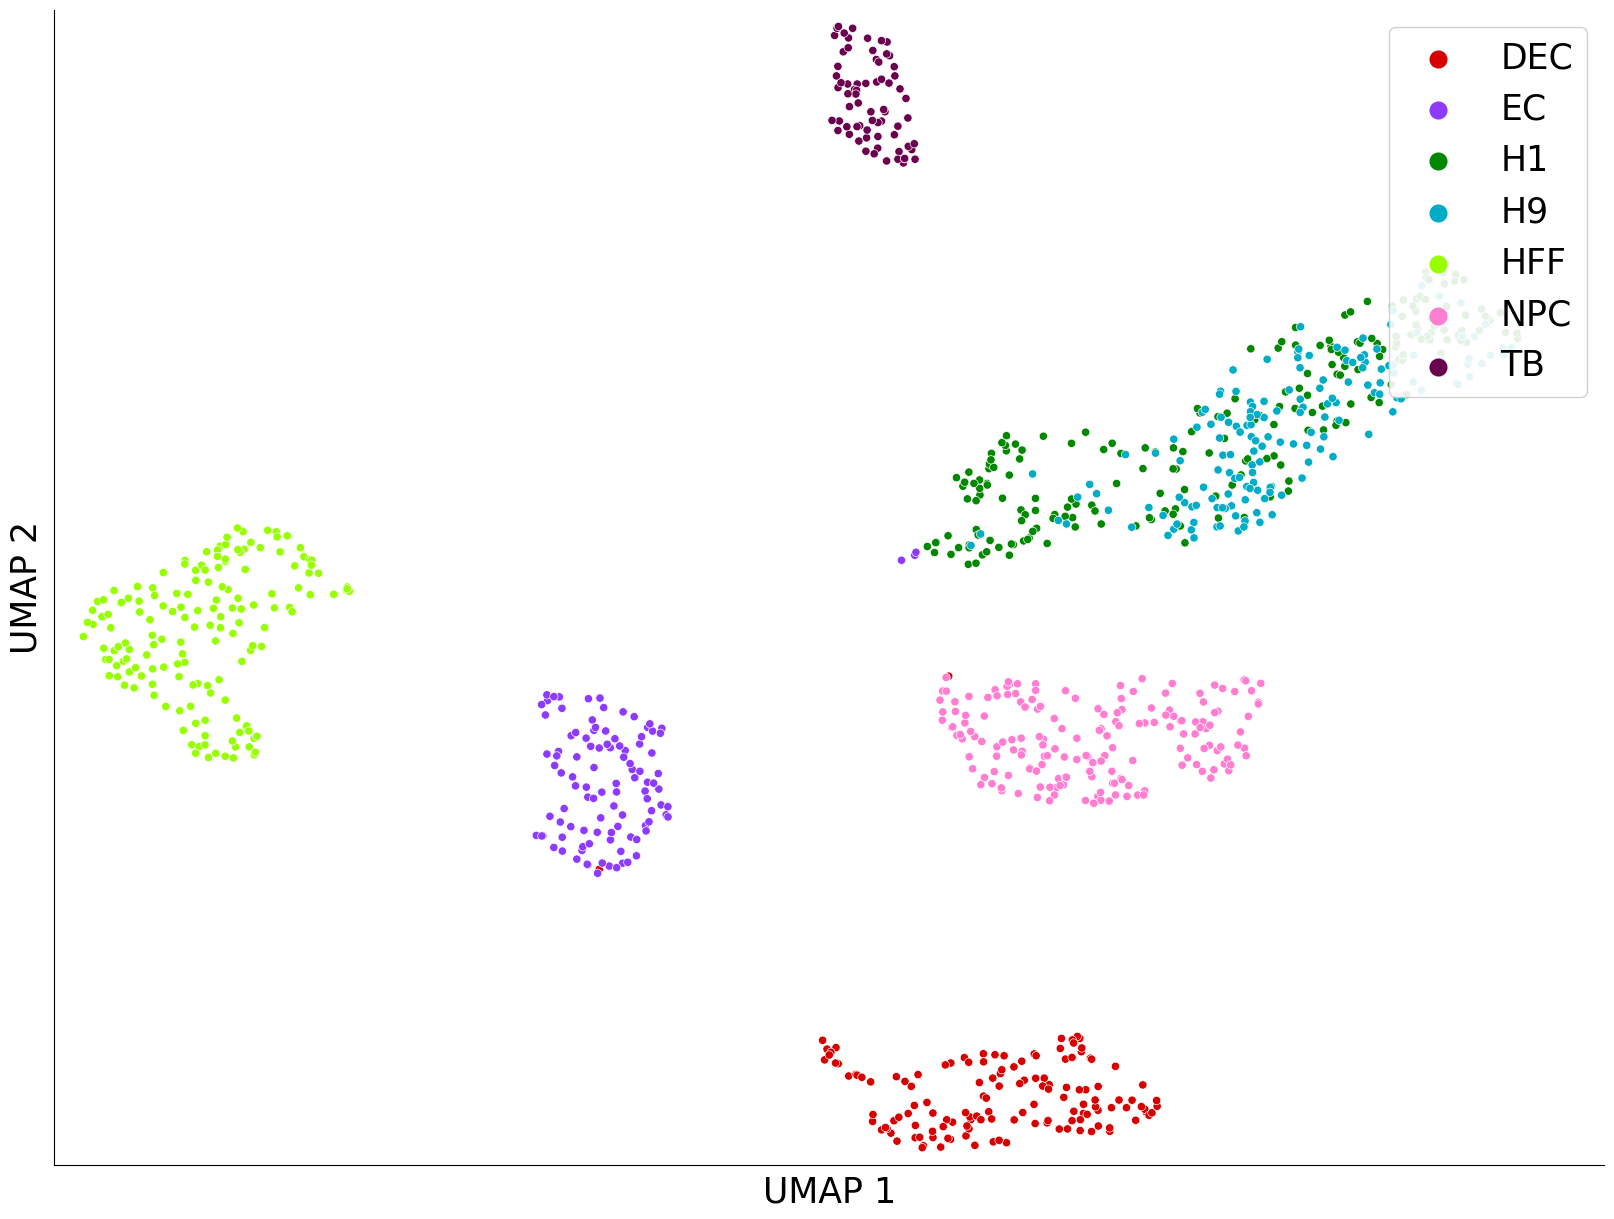

In [27]:
end_label = [label.split("_")[0] for label in end_scdm.index.to_list()]

end_scdm_emb = get_embedding(end_scdm.values)
draw_umap(end_scdm_emb, end_label)

## DCA results

In [28]:
endoderm_dca = pd.read_csv('/home/dengyf2000/bis687-project/data/endoderm/mean.tsv', sep='\t', index_col=0)
endoderm_dca = endoderm_dca.T[adata.var_names]

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


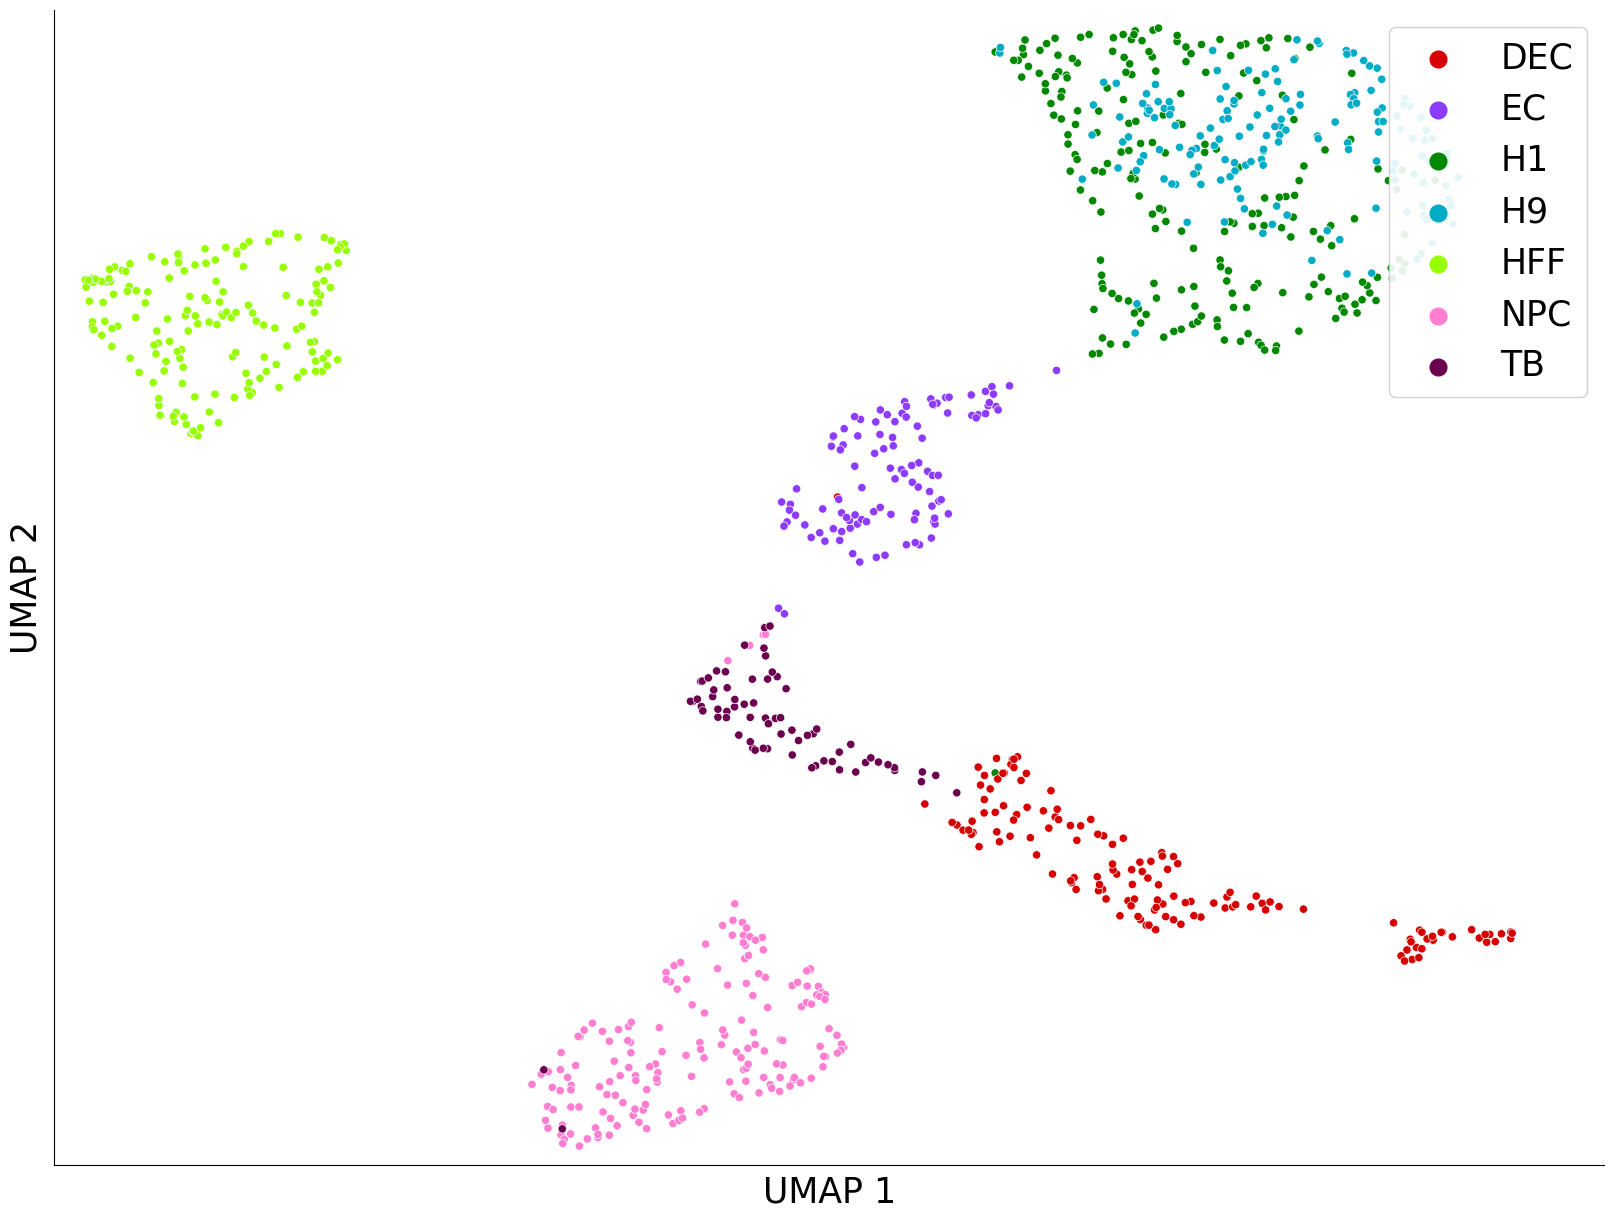

In [29]:
end_dca_emb = get_embedding(endoderm_dca.values)
draw_umap(end_dca_emb, end_label)